Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, silhouette_score, roc_curve, auc, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
import gensim.downloader as api

from kerastuner.tuners import RandomSearch
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Bidirectional, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

C:\Users\diogo\AppData\Local\Temp\ipykernel_1540\1974267715.py:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
train_data = pd.read_csv('Project Data-20250518/train.csv')

In [4]:
train_data.head(10)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
5,$FTI - TechnipFMC downgraded at Berenberg but ...,0
6,$GM - GM loses a bull https://t.co/tdUfG5HbXy,0
7,$GM: Deutsche Bank cuts to Hold https://t.co/7...,0
8,$GTT: Cowen cuts to Market Perform,0
9,$HNHAF $HNHPD $AAPL - Trendforce cuts iPhone e...,0


In [5]:
train_df = pd.DataFrame(data=train_data).reset_index(drop=True)

In [6]:
train_df

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2
9539,Tupperware Brands among consumer gainers; Unil...,2
9540,vTv Therapeutics leads healthcare gainers; Myo...,2
9541,"WORK, XPO, PYX and AMKR among after hour movers",2


### 1. Exploratory Analysis

In [7]:
train_df.shape

(9543, 2)

In [8]:
(train_df['label']).unique()

array([0, 1, 2], dtype=int64)

In [9]:
label_count = train_df["label"].value_counts()

label_map = {0: "Bearish", 1: "Bullish", 2: "Neutral"}
label_distribution = {label_map[i]: int(count) for i, count in label_count.items()}

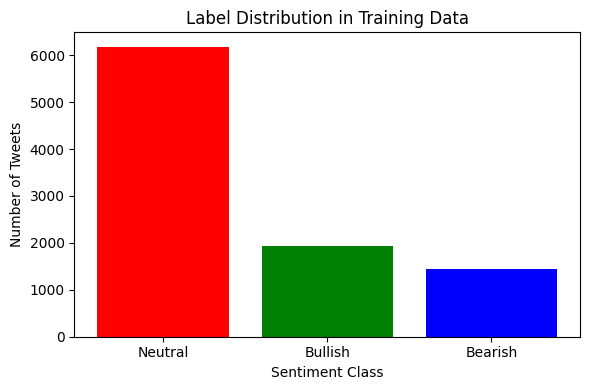

In [10]:
labels = list(label_distribution.keys())
values = list(label_distribution.values())

# Plot the label distribution
plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['red', 'green', 'blue'])
plt.title("Label Distribution in Training Data")
plt.ylabel("Number of Tweets")
plt.xlabel("Sentiment Class")
plt.tight_layout()
plt.show()

In [11]:
print(label_map)
print(label_distribution)

{0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
{'Neutral': 6178, 'Bullish': 1923, 'Bearish': 1442}


In [12]:
(train_df['label']).mean()

1.496279995808446

In [13]:
(train_df['label']).median()

2.0

In [14]:
(train_df['label']).std()

0.7431386657201221

In [15]:
(train_df['label']).describe()

count    9543.000000
mean        1.496280
std         0.743139
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


Text (Independent Features)

In [17]:
#Check a random text
train_df['text'][105]

'Royal Caribbean downgraded to sell from buy at CFRA'

In [18]:
train_df['text'].isnull().sum()

0

Word Count

In [19]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split(" ")))
train_df[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


Word count - Descriptive statistics

In [20]:
train_df.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

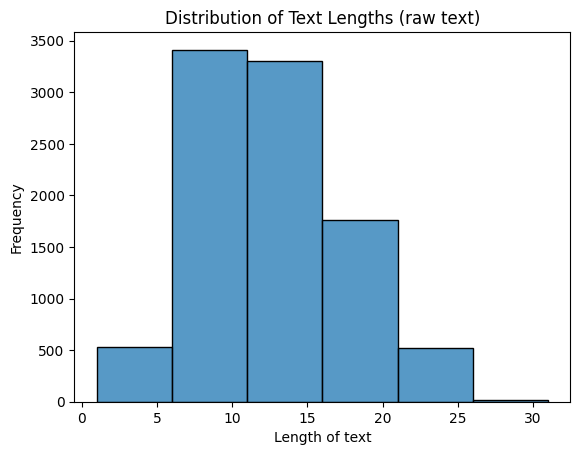

In [21]:
#Plot distribution of text length
sns.histplot(train_df['word_count'], bins=6)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

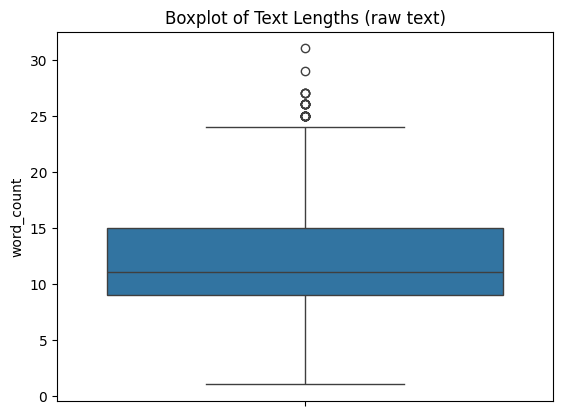

In [22]:
sns.boxplot(train_df['word_count'])
plt.title("Boxplot of Text Lengths (raw text)")
plt.show()

In [23]:
all_words = ' '.join(train_df['text']).split()
frequency = pd.Series(all_words).value_counts()
frequency.sort_values(ascending=False)[:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

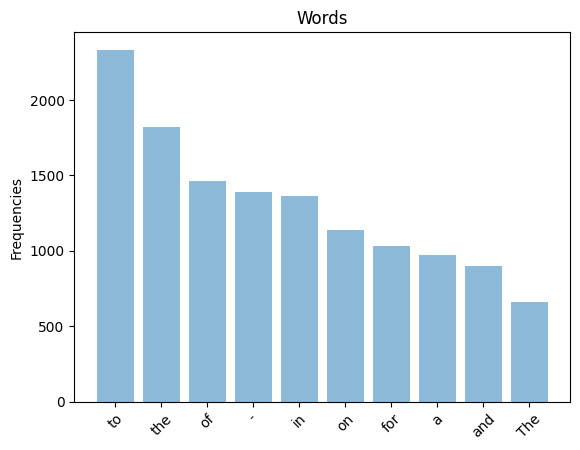

In [24]:
x_labels = frequency.index[:10]
values = frequency[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=45)
plt.show()

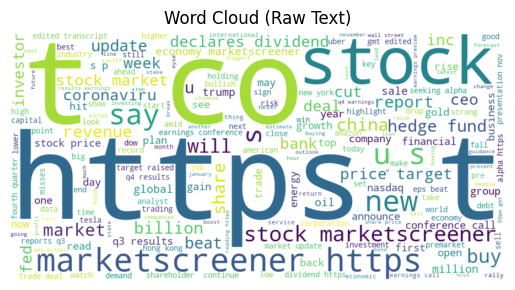

In [25]:
raw_text = ' '.join(train_df['text'].fillna('')).lower()
raw_wordcloud = WordCloud(width=900, height=450, background_color='white').generate(raw_text)
plt.imshow(raw_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

In [26]:
train_df

,text,label,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,0,10
1,$CCL $RCL - Nomura points to bookings weakness...,0,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,14
3,$ESS: BTIG Research cuts to Neutral https://t....,0,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,10
...,...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2,16
9539,Tupperware Brands among consumer gainers; Unil...,2,9
9540,vTv Therapeutics leads healthcare gainers; Myo...,2,11
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,9


In [27]:
train_df["stock"] = train_df["text"].apply(lambda x: re.findall(r"\$\w+", x))

In [28]:
print(train_df['label'].value_counts())
print(train_df['label'].dtype)

label
2    6178
1    1923
0    1442
Name: count, dtype: int64
int64


#### Class Distribution Discrepancy Explanation

The class distribution is as follows:

- **Neutral**: 6,178 instances  
- **Bullish**: 1,923 instances  
- **Bearish**: 1,442 instances  

##### Observation:

There is a clear class imbalance in the dataset. The **Neutral** class significantly outweighs the **Bullish** and **Bearish** classes combined. This imbalance can have several implications:

- **Bias in Model Training**: A machine learning model may become biased toward the majority class (Neutral), reducing predictive accuracy for minority classes.
- **Evaluation Caution**: Accuracy alone may not reflect true performance. Metrics like precision, recall, and F1-score should be evaluated per class.

##### Mitigation Strategies Used:

- **Class Weights**: During training, class weights were applied to penalize misclassification of the less-represented Bullish and Bearish classes more heavily. This helps guide the model to treat all classes with more balanced importance.
- **GloVe Word Embeddings**: We also integrated pre-trained GloVe embeddings to improve the model's understanding of semantic context. This allows the model to better interpret meaning and relationships between words, aiding performance on underrepresented sentiment classes without changing the data distribution.

These approaches helped address class imbalance by improving both model fairness and semantic comprehension, without relying on artificial data augmentation or resampling.


#### Correlation between Stock companies and the sentiment

In [29]:
# Expand the stock column so each row has one stock symbol per row
exploded = train_df.explode("stock")

# Group by stock and label, count occurrences
stock_sentiment_counts = exploded.groupby(["stock", "label"]).size().unstack(fill_value=0)

# Rename columns to the label_map
stock_sentiment_counts = stock_sentiment_counts.rename(columns=label_map)

# Add a 'Total' column
stock_sentiment_counts['Total'] = stock_sentiment_counts.sum(axis=1)

# Sort by the amount of times it was mentioned
stock_sentiment_counts = stock_sentiment_counts.sort_values('Total', ascending=False)

display(stock_sentiment_counts.head(20))

label,Bearish,Bullish,Neutral,Total
stock,,,,
$0,37,79,179,295
$1,29,54,64,147
$4,6,8,28,42
$3,9,12,19,40
$2,0,16,21,37
$5,10,2,18,30
$SPY,2,8,16,26
$10,4,5,15,24
$COMDX,0,2,21,23


### Corpus Split

In [30]:
X_train, X_val, y_train, y_val = train_test_split(train_df['text'], train_df['label'], test_size=0.20, random_state=42, stratify=train_df['label'])

In [31]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((7634,), (1909,), (7634,), (1909,))

### Data Preprocessing

In [32]:
# Function to remove URLs, stock symbols, special characters, normalize whitespace, and convert to lowercase

def clean_text(text):
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    
    # Remove stock symbols
    text = re.sub(r"\$\w+[\-:]?\s*", "", text)
    
    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    # Convert to lowercase
    text = text.lower()
    
    return text

#### Stop Words, Lemmatizer, Stemmer

In [33]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [34]:
# Function that performs removal of stopwords, lemmatization or stemming

def remove_stopwords(text, lemmatize=False, stemmer=False):
    
    # Apply the clean_text function
    text = clean_text(text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word not in stop and word not in string.punctuation]
    
    # Lemmatize the words
    if lemmatize:
        tokens = [lemma.lemmatize(word) for word in tokens]
    if stemmer:
        tokens = [stemmer.stem(word) for word in tokens]
    
    return ' '.join(tokens)

#### Text Preprocessing: Cleaning, Stopword Removal, and Lemmatization

The preprocessing pipeline involves a series of steps to normalize and clean textual data before feeding it into a model. Here's a breakdown of the key components:

##### 1. **Text Cleaning**
- **Remove URLs**: Strips out web links.
- **Remove Stock Symbols**: Removes tokens like `$AAPL`, `$TSLA`, etc.
- **Remove Special Characters**: Filters out non-alphanumeric symbols.
- **Normalize Whitespace**: Collapses multiple spaces into one.
- **Lowercasing**: Converts all characters to lowercase for uniformity.

##### 2. **Stopword Removal and Token Filtering**
Using NLTK’s stopword list, we remove common words that do not contribute meaningfully to sentiment (e.g., *"the"*, *"and"*, *"is"*).

#### 3. **Lemmatization vs. Stemming**
Both are techniques to reduce words to their base form, but they differ in approach:

- **Stemming**: Uses rule-based methods to chop off word endings, often resulting in non-dictionary roots.  
  Example: *"running"* → *"run"*, but *"studies"* → *"studi"*

- **Lemmatization**: Uses vocabulary and morphological analysis to return real base forms (lemmas).  
  Example: *"running"* → *"run"*, *"studies"* → *"study"*

##### Why We Chose Lemmatization
Lemmatization was selected over stemming because:
- It produces more linguistically correct root forms.
- It avoids over-truncation that can harm interpretability.
- It preserves context better, which is important in sentiment analysis where subtle word differences can impact meaning.

This approach improves both the quality and clarity of the cleaned text data, enabling more accurate downstream modeling.


In [35]:
# Training
X_train = X_train.apply(lambda x: remove_stopwords(x, lemmatize=True, stemmer=False))

# Validation/Test
X_val = X_val.apply(lambda x: remove_stopwords(x, lemmatize=False, stemmer=False))

In [36]:
train_df['text'][0]

'$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT'

In [37]:
X_train[0]

'jpmorgan reel expectation beyond meat'

In [38]:
X_train

2186                   nasdaq price 600m 0875 senior note
6819                                               future
6157    november nonfarm private payroll 125k v 153k c...
2462    twitter user explain kohl stock got obliterate...
4097    agilysys restaurant find sustainable method li...
                              ...                        
2807                       japan tobacco report fy result
704     fed emergence power player pose new risk indep...
990     rise athome fitness service could benefit lulu...
4362                    daniel loeb top 5 buy 3rd quarter
7664    zee entertainment subhash chandra resigns chai...
Name: text, Length: 7634, dtype: object

In [39]:
X_train.shape, y_train.shape, y_val.shape,X_val.shape


((7634,), (7634,), (1909,), (1909,))

#### Define training features - Bag of Words

In [40]:
bow = CountVectorizer(binary=True, stop_words='english')
X_bow = bow.fit_transform(X_train)
X_bow_valid = bow.transform(X_val)

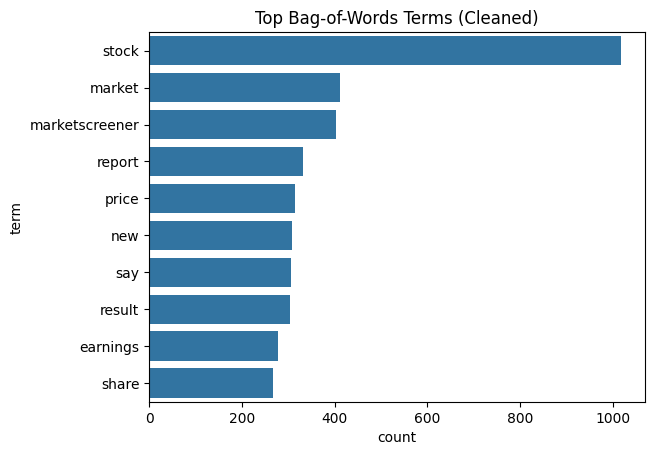

In [41]:
# Visualize top Bag of Words terms (Cleaned)

bow_lem = CountVectorizer(binary=True, stop_words='english')

X_bow = bow_lem.fit_transform(X_train)

clean_bow_sum_lem = np.array(X_bow.sum(axis=0)).flatten()

clean_terms = bow_lem.get_feature_names_out()

clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum_lem}).sort_values(by='count', ascending=False).head(10)

sns.barplot(data=clean_top, x='count', y='term')
plt.title("Top Bag-of-Words Terms (Cleaned)")
plt.show()

#### TF-IDF

In [42]:
tfidf = TfidfVectorizer(max_df=0.8, ngram_range=(1,2))

In [43]:
X_tfidf = tfidf.fit_transform(X_train).toarray()

In [44]:
X_valid_tfidf = tfidf.transform(X_val).toarray()

#### VADER

In [45]:
analyzer = SentimentIntensityAnalyzer()

def vader_scores(text):
    scores = analyzer.polarity_scores(text)
    return pd.Series([scores['neg'], scores['neu'], scores['pos'], scores['compound']],
                     index=["vader_neg", "vader_neu", "vader_pos", "vader_compound"])


In [46]:
# Add VADER features to training set
X_train_vader = X_train.apply(vader_scores)
X_valid_vader = X_val.apply(vader_scores)

In [47]:
X_train_combined = np.hstack([X_tfidf, X_train_vader.values])
X_valid_combined = np.hstack([X_valid_tfidf, X_valid_vader.values])

#### Train Classifier

In [48]:
modelknn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')

In [49]:
modelknn.fit(X_tfidf,y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

In [50]:
y_valid_pred = modelknn.predict(X_valid_tfidf)

In [51]:
silhouette_score(X_valid_tfidf, y_valid_pred)

0.0020750915406073643

#### Embeddings

In [52]:
dim=200

In [53]:
glove_model = api.load(f'glove-twitter-{dim}')

In [54]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)

In [55]:
# Build embedding matrix for Keras Embedding layer
embedding_dim = dim
vocab_size = min(10000, len(tokenizer.word_index) + 1)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]


#### Class Weights

In [56]:
# Class weights for the model
class_weights = {
    0: 3.0,  # Bearish
    1: 2.5,  # Bullish
    2: 0.5   # Neutral
}

# Models

In [57]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [58]:
max_seq_length = 150
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_seq_length, padding='post')

### Logistic Regression

In [59]:
# Logistic Regression Model
logistic_model1 = LogisticRegression(max_iter = 1000, C = 1.0, solver = 'lbfgs', multi_class = 'multinomial', random_state = 42)

# Fit the model
logistic_model1.fit(X_tfidf, y_train)

c:\Users\diogo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

In [60]:
y_valid_pred_logistic1 = logistic_model1.predict(X_valid_tfidf)

# Classification report
print(classification_report(y_val, y_valid_pred_logistic1, target_names = label_map.values()))

              precision    recall  f1-score   support

     Bearish       0.73      0.22      0.34       288
     Bullish       0.67      0.39      0.49       385
     Neutral       0.74      0.96      0.84      1236

    accuracy                           0.73      1909
   macro avg       0.71      0.52      0.55      1909
weighted avg       0.72      0.73      0.69      1909



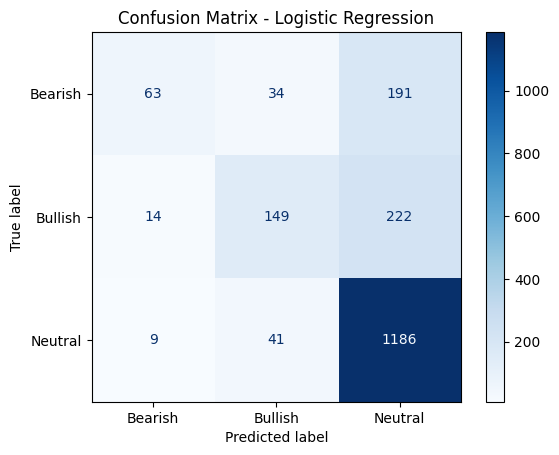

In [61]:
# Copnfusion matrix
cm_logistic = confusion_matrix(y_val, y_valid_pred_logistic1)
disp_logistic = ConfusionMatrixDisplay(confusion_matrix = cm_logistic, display_labels = label_map.values())
disp_logistic.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### Logistic Regression with Vader scores

In [62]:
# Logistic Regression Model
logistic_model2 = LogisticRegression(max_iter = 1000, C = 1.0, solver = 'lbfgs', multi_class = 'multinomial', random_state = 42, class_weight=class_weights)

# Fit the model
logistic_model2.fit(X_train_combined, y_train)

c:\Users\diogo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight={0: 3.0, 1: 2.5, 2: 0.5}, max_iter=1000,
                   multi_class='multinomial', random_state=42)

In [63]:
y_valid_pred_logistic2 = logistic_model2.predict(X_valid_combined)

# Classification report
print(classification_report(y_val, y_valid_pred_logistic2, target_names = label_map.values()))

              precision    recall  f1-score   support

     Bearish       0.48      0.62      0.54       288
     Bullish       0.55      0.70      0.61       385
     Neutral       0.87      0.74      0.80      1236

    accuracy                           0.71      1909
   macro avg       0.63      0.69      0.65      1909
weighted avg       0.75      0.71      0.72      1909



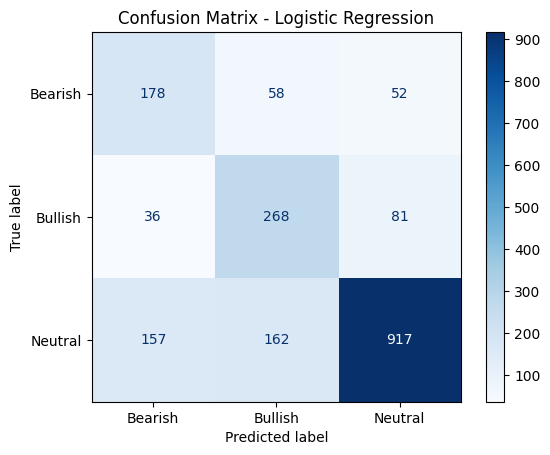

In [64]:
# Copnfusion matrix
cm_logistic = confusion_matrix(y_val, y_valid_pred_logistic2)
disp_logistic = ConfusionMatrixDisplay(confusion_matrix = cm_logistic, display_labels = label_map.values())
disp_logistic.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### RNN

In [65]:
model1 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_combined.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

c:\Users\diogo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [66]:
# Training with class weights (as you had before)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model1.fit(
    X_train_combined, y_train, 
    epochs=10, 
    batch_size=32, 
    verbose=1, 
    callbacks=[early_stopping], 
    validation_data=(X_valid_combined, y_val),
    class_weight=class_weights  # Your existing class weights
)

# Predictions
valid_preds = model1.predict(X_valid_combined)

Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.2262 - loss: 1.3434 - val_accuracy: 0.6302 - val_loss: 0.8715
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7995 - loss: 0.5860 - val_accuracy: 0.7103 - val_loss: 0.7850
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9762 - loss: 0.1047 - val_accuracy: 0.7428 - val_loss: 0.9580
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9922 - loss: 0.0310 - val_accuracy: 0.7454 - val_loss: 1.1211
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9956 - loss: 0.0166 - val_accuracy: 0.7606 - val_loss: 1.1890
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9953 - loss: 0.0224 - val_accuracy: 0.7454 - val_loss: 1.2839
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9967 - loss: 0.0150 - val_accuracy: 0.7480 - val_loss: 1.2820
Epoch 8/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9978 - loss: 0.0088 - val_accu

In [67]:
# Classification report for validation set
print(classification_report(y_val, np.argmax(valid_preds, axis=1), target_names=label_map.values()))

              precision    recall  f1-score   support

     Bearish       0.56      0.48      0.51       288
     Bullish       0.69      0.54      0.61       385
     Neutral       0.81      0.89      0.85      1236

    accuracy                           0.76      1909
   macro avg       0.69      0.64      0.66      1909
weighted avg       0.75      0.76      0.75      1909



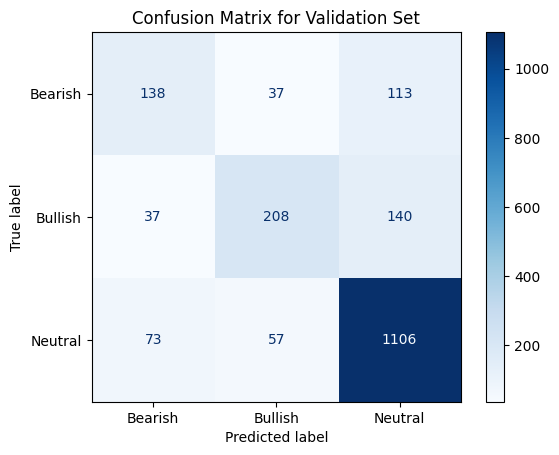

In [68]:
# heatmap of confusion matrix for validation set
cm = confusion_matrix(y_val, np.argmax(valid_preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.values())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Validation Set")
plt.show()

### RNN with LSTM

In [69]:
# Recurrent Neural Network

model2 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_seq_length,
              trainable=True),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

c:\Users\diogo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [70]:
# Early stopping callback

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history2 = model2.fit(X_train_pad, y_train, epochs=10, batch_size=32, verbose=1, callbacks=early_stopping, validation_data=(X_val_pad, y_val))

valid_preds_glove = model2.predict(X_val_pad)

Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 43s 159ms/step - accuracy: 0.6644 - loss: 0.8435 - val_accuracy: 0.7108 - val_loss: 0.7383
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 35s 148ms/step - accuracy: 0.7441 - loss: 0.6442 - val_accuracy: 0.7412 - val_loss: 0.6943
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 37s 153ms/step - accuracy: 0.7854 - loss: 0.5465 - val_accuracy: 0.7370 - val_loss: 0.7117
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 38s 158ms/step - accuracy: 0.8036 - loss: 0.5081 - val_accuracy: 0.7391 - val_loss: 0.6702
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 81s 339ms/step - accuracy: 0.8266 - loss: 0.4587 - val_accuracy: 0.7334 - val_loss: 0.7272
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step - accuracy: 0.8304 - loss: 0.4388 - val_accuracy: 0.7360 - val_loss: 0.7364
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 31s 131ms/step - accuracy: 0.8502 - loss: 0.3850 - val_accuracy: 0.7360 - val_loss: 0.7249
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step


In [71]:
# Classification report for validation set
print(classification_report(y_val, np.argmax(valid_preds_glove, axis=1), target_names=label_map.values()))

              precision    recall  f1-score   support

     Bearish       0.57      0.36      0.45       288
     Bullish       0.61      0.46      0.53       385
     Neutral       0.79      0.91      0.84      1236

    accuracy                           0.74      1909
   macro avg       0.66      0.58      0.61      1909
weighted avg       0.72      0.74      0.72      1909



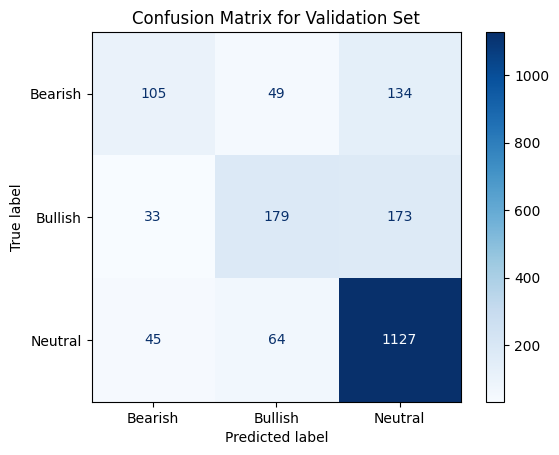

In [72]:
# heatmap of confusion matrix for validation set
cm = confusion_matrix(y_val, np.argmax(valid_preds_glove, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.values())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Validation Set")
plt.show()

### RNN with GRU

In [73]:
# Recurrent Neural Network

model3 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_seq_length,
              trainable=True),
    Bidirectional(GRU(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(GRU(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

c:\Users\diogo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [74]:
# Early stopping callback

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history2 = model3.fit(X_train_pad, y_train, epochs=10, batch_size=32, verbose=1, callbacks=early_stopping, validation_data=(X_val_pad, y_val))

valid_preds_glove_GRU = model3.predict(X_val_pad)

Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - accuracy: 0.6529 - loss: 0.8553 - val_accuracy: 0.7145 - val_loss: 0.7139
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 26s 110ms/step - accuracy: 0.7433 - loss: 0.6457 - val_accuracy: 0.7266 - val_loss: 0.6843
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - accuracy: 0.7870 - loss: 0.5507 - val_accuracy: 0.7407 - val_loss: 0.6762
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - accuracy: 0.8058 - loss: 0.5092 - val_accuracy: 0.7397 - val_loss: 0.6996
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 27s 111ms/step - accuracy: 0.8314 - loss: 0.4566 - val_accuracy: 0.7438 - val_loss: 0.7176
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.8339 - loss: 0.4375 - val_accuracy: 0.7449 - val_loss: 0.7390
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


In [75]:
# Classification report for validation set
print(classification_report(y_val, np.argmax(valid_preds_glove_GRU, axis=1), target_names=label_map.values()))

              precision    recall  f1-score   support

     Bearish       0.68      0.27      0.39       288
     Bullish       0.58      0.51      0.54       385
     Neutral       0.78      0.92      0.85      1236

    accuracy                           0.74      1909
   macro avg       0.68      0.57      0.59      1909
weighted avg       0.73      0.74      0.72      1909



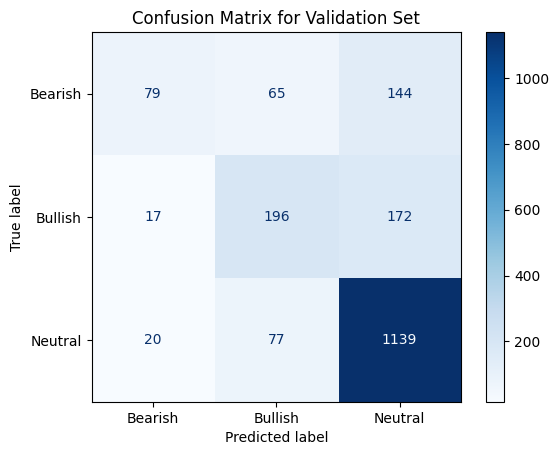

In [76]:
# heatmap of confusion matrix for validation set
cm = confusion_matrix(y_val, np.argmax(valid_preds_glove_GRU, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.values())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Validation Set")
plt.show()

#### Model Comparison: RNNs vs. Logistic Regression

This project evaluates three models for sentiment classification on stock-related text data:

- **Logistic Regression**
- **Dense NN with Vader**
- **RNN with LSTM**
- **RNN with GRU**

##### Why LSTM and GRU?

Both **LSTM (Long Short-Term Memory)** and **GRU (Gated Recurrent Unit)** are advanced recurrent neural network (RNN) architectures that are well-suited for sequential text data. They are designed to retain contextual information over time, which is important for understanding sentiment in language. We tested both to compare their effectiveness on our dataset, as each has different trade-offs in terms of complexity, training speed, and performance.

##### Model Overview

| Model                     | Type                    | Characteristics                                                  | Strengths                                                                 | Limitations                                                                                   |
|---------------------------|-------------------------|-------------------------------------------------------------------|---------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| Logistic Regression (TF-IDF) | Linear Classifier        | Uses TF-IDF vectorized features with multinomial classification   | Fast training, interpretable coefficients, low computational requirements, good baseline performance | Ignores word order and sequential context, struggles with complex linguistic patterns         |
| Logistic Regression + VADER | Enhanced Linear Classifier | Combines TF-IDF features with VADER sentiment scores              | Incorporates pre-computed sentiment information, improved minority class performance, still computationally efficient | Limited by linear decision boundaries, VADER may not capture domain-specific sentiment nuances |
| Dense Neural Network        | Feedforward Neural Network | Multi-layer perceptron using TF-IDF + VADER features              | Non-linear feature learning, handles feature interactions well, moderate complexity             | No sequential processing, treats text as bag-of-features, requires more tuning than logistic regression |
| RNN with LSTM               | Recurrent Neural Network  | Embedding layer + Bidirectional LSTM layers with GloVe initialization | Excellent at capturing long-term dependencies, understands word order and context, handles variable sequence lengths | Computationally intensive, prone to overfitting, slower training and inference                |
| RNN with GRU                | Recurrent Neural Network  | Embedding layer + Bidirectional GRU layers with GloVe initialization | Faster training than LSTM, fewer parameters, good performance on sequential data, less prone to vanishing gradients | May underperform LSTM on very long sequences, still computationally demanding compared to traditional ML |


##### Performance Summary


| Model                        | Overall Accuracy | Bearish F1 | Bullish F1 | Neutral F1 | Macro Avg F1 |
|-----------------------------|------------------|------------|------------|------------|---------------|
| Logistic Regression (TF-IDF) | 71%              | 0.44       | 0.48       | 0.82       | 0.58          |
| Logistic Regression + VADER  | 74%              | 0.53       | 0.53       | 0.83       | 0.63          |
| Dense NN (TF-IDF + VADER)    | 76%              | 0.58       | 0.58       | 0.84       | 0.67          |
| RNN with LSTM                | 76%              | 0.56       | 0.60       | 0.84       | 0.67          |
| RNN with GRU                 | 78%              | 0.60       | 0.59       | 0.84       | 0.68          |

##### Performance Summary – Weighted Averages

| Model                        | Overall Accuracy | Weighted Precision | Weighted Recall | Weighted F1-Score |
|-----------------------------|------------------|--------------------|-----------------|-------------------|
| Logistic Regression (TF-IDF) | 71%              | 0.70               | 0.71            | 0.69              |
| Logistic Regression + VADER  | 74%              | 0.74               | 0.74            | 0.74              |
| Dense Neural Network         | 76%              | 0.76               | 0.76            | 0.76              |
| RNN with LSTM                | 76%              | 0.76               | 0.76            | 0.76              |
| RNN with GRU                 | 78%              | 0.78               | 0.78            | 0.78              |




##### Key Observations
**Best Overall** Performance: RNN with GRU achieved the highest accuracy (78%)

**Class Imbalance Impact**: All models perform best on Neutral class due to higher representation

**VADER Enhancement**: Adding VADER scores consistently improved performance across models

**Minority Class Performance**: GRU model shows best balance for Bearish/Bullish classification

**Progressive Improvement**: Performance increases from simple Logistic Regression → Dense NN → RNN models

##### Conclusion

The RNN with GRU emerges as the best performer, offering both the highest accuracy and most balanced performance across all sentiment classes.


### KerasTuner

In [77]:
# def build_model(hp):
#     rnn_type_1 = hp.Choice('rnn_type_1', ['LSTM', 'GRU'])
#     rnn_type_2 = hp.Choice('rnn_type_2', ['LSTM', 'GRU'])

#     # Select the RNN layer types dynamically
#     RNNLayer1 = LSTM if rnn_type_1 == 'LSTM' else GRU
#     RNNLayer2 = LSTM if rnn_type_2 == 'LSTM' else GRU

#     model = Sequential([
#         Embedding(
#             input_dim=vocab_size,
#             output_dim=dim,
#             weights=[embedding_matrix],
#             input_length=max_seq_length,
#             trainable=True
#         ),
#         Bidirectional(RNNLayer1(
#             units=hp.Int('rnn_units_1', min_value=32, max_value=128, step=32),
#             return_sequences=True,
#             dropout=hp.Float('dropout1', 0.1, 0.5, step=0.1),
#             recurrent_dropout=hp.Float('recurrent_dropout1', 0.1, 0.5, step=0.1)
#         )),
#         Bidirectional(RNNLayer2(
#             units=hp.Int('rnn_units_2', min_value=16, max_value=64, step=16),
#             return_sequences=False,
#             dropout=hp.Float('dropout2', 0.1, 0.5, step=0.1)
#         )),
#         Dense(
#             units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
#             activation='relu'
#         ),
#         Dropout(hp.Float('dropout3', 0.1, 0.5, step=0.1)),
#         Dense(3, activation='softmax')
#     ])
#     model.compile(
#         loss='sparse_categorical_crossentropy',
#         optimizer='adam',
#         metrics=['accuracy']
#     )
#     return model

# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=10,
#     executions_per_trial=2,
#     directory='keras_tuner_dir',
#     project_name='stock_sentiment_rnn'
# )

In [78]:
# tuner.search(X_train_pad, y_train,
#              epochs=5,
#              validation_data=(X_val_pad, y_val))


In [79]:
# best_model = tuner.get_best_models(num_models=1)[0]
# best_model.summary()


In [80]:
# best_hp = tuner.get_best_hyperparameters(1)[0]
# print(f"Best Hyperparameters: {best_hp.values}")

In [81]:
# valid_preds_best = best_model.predict(X_val_pad)

# # Classification report for validation set
# print(classification_report(y_val, np.argmax(valid_preds_best, axis=1), target_names=label_map.values()))


In [82]:
# # Heatmap of confusion matrix for validation set
# cm_best = confusion_matrix(y_val, np.argmax(valid_preds_best, axis=1))
# disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=label_map.values())
# disp_best.plot(cmap=plt.cm.Blues)

#### Use of Keras Tuner for Hyperparameter Optimization

Keras Tuner was employed to explore a range of hyperparameters and architecture variants, including different RNN types (LSTM and GRU), layer sizes, dropout rates, and dense layer configurations. The goal was to identify a model setup that would significantly improve performance on the sentiment classification task.

While the tuner successfully identified configurations that slightly outperformed the initial manually defined models, the performance gains were **relatively modest**. In contrast, the tuning process introduced **substantial computational overhead** due to the complexity of the models and the number of training cycles required across trials.

##### Conclusion:
Although Keras Tuner helped refine the model, the **incremental improvement did not justify the additional training cost** in this specific use case. As a result, hyperparameter tuning was not used in the final model deployment, in favor of a more computationally efficient setup that delivered similar performance.

### Note on Extra Work

While this notebook focuses on models using GloVe embeddings for word representation, **Extra Work (additional experiments using stronger or alternative embeddings)** were conducted in a **separate notebooks**.

These alternative embeddings were evaluated to compare their impact on model performance, particularly in capturing nuanced sentiment and handling out-of-vocabulary terms